# House Prices (v1)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

# Evaluation index is RMSE, so prepare a library calculatable the mean squared error.
from sklearn.metrics import mean_squared_error

In [2]:
DF_TRAIN = pd.read_csv('./raw_data/train.csv')
DF_TEST = pd.read_csv('./raw_data/test.csv')
SAMPLE_SUBMISSION = pd.read_csv('./raw_data/sample_submission.csv')

# data confirmation
display(DF_TRAIN.head(3))
display(DF_TEST.head(3))
display(SAMPLE_SUBMISSION.head(3))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570


In [3]:
DF_TRAIN.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [4]:
DF_TRAIN['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [5]:
def concat_train_and_test_datasets(dataset_train, dataset_test):
    return pd.concat(
        [dataset_train, dataset_test],
        sort=False
    ).reset_index(drop=True)


df_all = concat_train_and_test_datasets(DF_TRAIN, DF_TEST)

df_all

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [6]:
objective_categories = df_all.columns[df_all.dtypes == 'object']

print(objective_categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [7]:
# Label encode
label_encodered_df_all = df_all.copy()

for category in objective_categories:
    label_encoder = LabelEncoder()
    
    label_encodered_df_all[category].fillna(
        'missing_value', inplace=True
    )
    label_encoder.fit(label_encodered_df_all[category])
    label_encodered_df_all[category] = label_encoder.transform(label_encodered_df_all[category])
    label_encodered_df_all[category] = label_encodered_df_all[category].astype('category')

In [8]:
train = label_encodered_df_all[~label_encodered_df_all['SalePrice'].isnull()]
test = label_encodered_df_all[label_encodered_df_all['SalePrice'].isnull()]

display(train.head(3))
display(test.head(3))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500.0


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1460,1461,20,2,80.0,11622,1,2,3,3,0,...,0,3,2,4,0,6,2010,8,4,NaN
1461,1462,20,3,81.0,14267,1,2,0,3,0,...,0,3,4,0,12500,6,2010,8,4,NaN
1462,1463,60,3,74.0,13830,1,2,0,3,0,...,0,3,2,4,0,3,2010,8,4,NaN


In [9]:
train_X = train.drop(
    ['SalePrice', 'Id'],
    axis=1
)
train_y = train['SalePrice']

kf = KFold(n_splits=3)

lgb_params = {
    'objective': 'regression',
    'random_seed': 1000
}

In [10]:
models = []
rmses = []
out_of_fold = np.zeros(
    len(train_X)
)


def construct_kfold_models_and_store_predictions(model_arr, rmses_arr, oof, train_Y, use_logarithmize: bool) -> None:
    callbacks = [
        lgb.early_stopping(20),
        lgb.log_evaluation(10)
    ]

    for train_index, value_index in kf.split(train_X):
        X_train = train_X.iloc[train_index]
        X_valid = train_X.iloc[value_index]
        y_train = train_Y.iloc[train_index]
        y_valid = train_Y.iloc[value_index]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(
            X_valid,
            y_valid,
            reference=lgb_train
        )

        gbm = lgb.train(
            lgb_params,
            train_set=lgb_train,
            valid_sets=lgb_eval,
            num_boost_round=100,
            callbacks=callbacks
        )

        y_pred = gbm.predict(
            X_valid,
            num_iteration=gbm.best_iteration
        )
        rmse = np.sqrt(mean_squared_error(
            np.log(y_valid) if use_logarithmize else y_valid,
            np.log(y_pred) if use_logarithmize else y_pred
        ))

        model_arr += [gbm]
        rmses_arr += [rmse]
        oof[value_index] = y_pred


construct_kfold_models_and_store_predictions(
    models,
    rmses,
    out_of_fold,
    train_y,
    True
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2964
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 179726.031860
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 1.57807e+09
[20]	valid_0's l2: 7.38516e+08
[30]	valid_0's l2: 5.93255e+08
[40]	valid_0's l2: 5.6061e+08
[50]	valid_0's l2: 5.48225e+08
[60]	valid_0's l2: 5.46182e+08
[70]	valid_0's l2: 5.51735e+08
Early stopping, best iteration is:
[55]	valid_0's l2: 5.45194e+08
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2985
[LightGBM] [Info] Number of data points in the

/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[30]	valid_0's l2: 1.03767e+09
[40]	valid_0's l2: 9.7989e+08
[50]	valid_0's l2: 9.47475e+08
[60]	valid_0's l2: 9.27892e+08
[70]	valid_0's l2: 9.20973e+08
Early stopping, best iteration is:
[55]	valid_0's l2: 5.45194e+08
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3005
[LightGBM] [Info] Number of data points in the train set: 974, number of used features: 75
[LightGBM] [Info] Start training from score 182112.591376
[10]	valid_0's l2: 1.80296e+09
[20]	valid_0's l2: 1.02271e+09
[30]	valid_0's l2: 8.68838e+08
[40]	valid_0's l2: 8.41872e+08
[50]	valid_0's l2: 8.35433e+08
[60]	valid_0's l2: 8.28083e+08
[70]	valid_0's l2: 8.25289e+08
Early stopping, best iteration is:
[55]	valid_0's l2: 5.45194e+08


/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [11]:
print(rmses)

[0.12719558859476138, 0.1481698339125757, 0.13266748681202264]


In [12]:
# Average RMSE
sum(rmses) / len(rmses)

0.1360109697731199

<AxesSubplot: xlabel='Id', ylabel='SalePrice'>

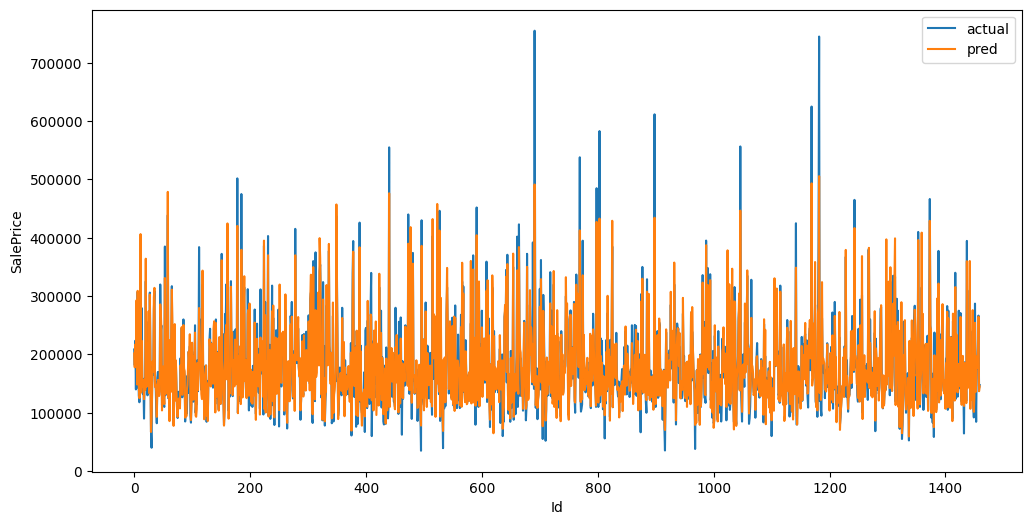

In [13]:
# Visualize actual and predicted values
comparison_actual_and_pred = pd.DataFrame({
    'actual': train_y,
    'pred': out_of_fold
})

comparison_actual_and_pred.plot(
    figsize=(12, 6),
    xlabel='Id',
    ylabel='SalePrice'
)

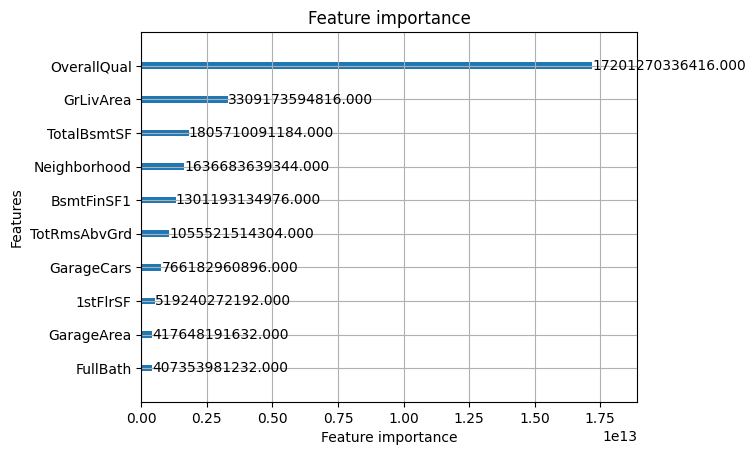

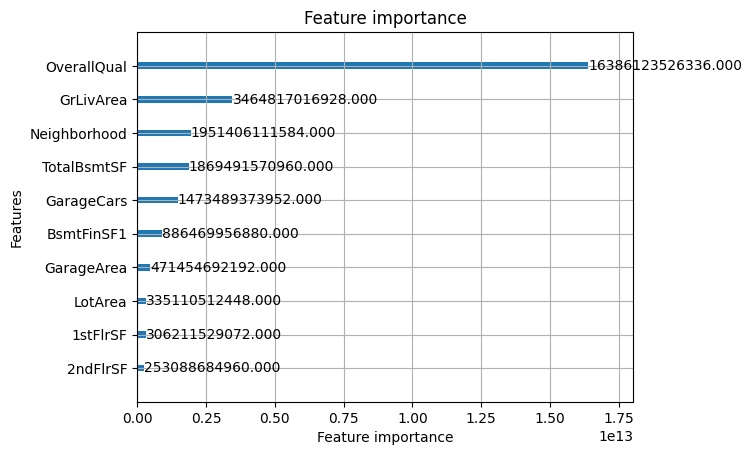

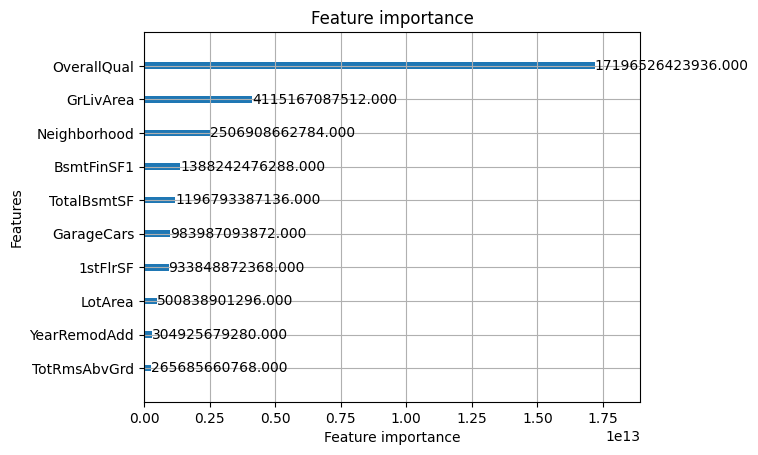

In [14]:
# Importance levet of each variable
for model in models:
    lgb.plot_importance(
        model,
        importance_type='gain',
        max_num_features=10
    )

In [15]:
# Objective variable 'SalePrice' details
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot: ylabel='Frequency'>

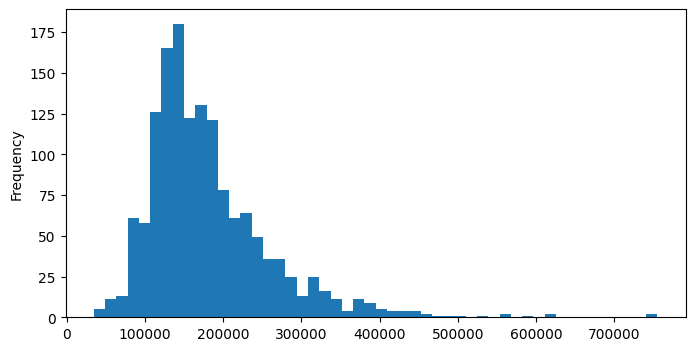

In [16]:
train['SalePrice'].plot.hist(figsize=(8, 4), bins=50)

- Seems to be a tendency toward a __Poisson distribution__.
- So __logarithmize__ the objective variable an
d optimize it for the evaluation index.

In [17]:
sale_price_logarithmized = np.log(train['SalePrice'])

sale_price_logarithmized

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

<AxesSubplot: ylabel='Frequency'>

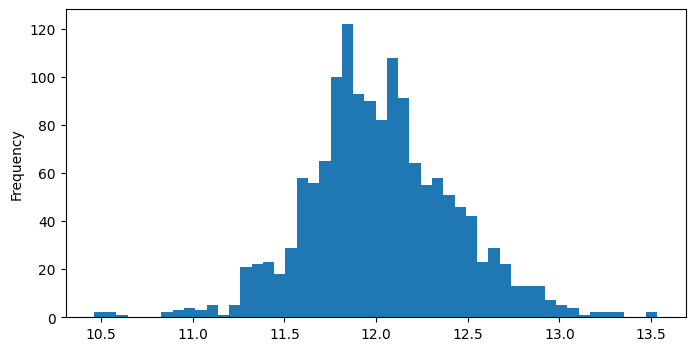

In [18]:
sale_price_logarithmized.plot.hist(figsize=(8, 4), bins=50)

In [19]:
train['SalePrice_logarithmized'] = sale_price_logarithmized

train_y_v2 = train['SalePrice_logarithmized']
models_v2 = []
rmses_v2 = []

construct_kfold_models_and_store_predictions(
    models_v2,
    rmses_v2,
    out_of_fold,
    train_y_v2,
    False
)

/tmp/ipykernel_7282/1890739959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['SalePrice_logarithmized'] = sale_price_logarithmized
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2964
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 12.017607
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0436707
[20]	valid_0's l2: 0.0219638
[30]	valid_0's l2: 0.0178863
[40]	valid_0's l2: 0.0168272
[50]	valid_0's l2: 0.0165421
[60]	valid_0's l2: 0.0164067
[70]	valid_0's l2: 0.0163235
[80]	valid_0's l2: 0.0162611
[90]	valid_0's l2: 0.0162673
[100]	valid_0's l2: 0.0163207
Did not meet early stopping. Best iteration is:
[81]	valid_0's l2: 0.0162538
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`

/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[20]	valid_0's l2: 0.028109
[30]	valid_0's l2: 0.0235203
[40]	valid_0's l2: 0.0218816
[50]	valid_0's l2: 0.0212745
[60]	valid_0's l2: 0.0209102
[70]	valid_0's l2: 0.0207806
[80]	valid_0's l2: 0.0206708
[90]	valid_0's l2: 0.020634
[100]	valid_0's l2: 0.0206411
Did not meet early stopping. Best iteration is:
[81]	valid_0's l2: 0.0162538
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3005
[LightGBM] [Info] Number of data points in the train set: 974, number of used features: 75
[LightGBM] [Info] Start training from score 12.028565
[10]	valid_0's l2: 0.0390113
[20]	valid_0's l2: 0.0212181
[30]	valid_0's l2: 0.0176641
[40]	valid_0's l2: 0.0167935
[50]	valid_0's l2: 0.016452
[60]	valid_0's l2: 0.0162947
[70]	valid_0's l2: 0.0161933
[80]	valid_0's l2: 0.0162265
[90]	valid_0's l2: 0.0162094
Early stopping, best iteration is:
[72]	valid_0's l2: 0.016

/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [20]:
# Average RMSE (v2)
sum(rmses_v2) / len(rmses_v2)

0.13279748990713156

- RMSE values were slightly reduced and accuracy was slightly improved.

In [21]:
# Confirm missing values of Explanatory variables (for preprocessing)
df_all.isnull().sum().sort_values(
    ascending=False
).head(50)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageFinish      159
GarageQual        159
GarageCond        159
GarageYrBlt       159
GarageType        157
BsmtExposure       82
BsmtCond           82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
Functional          2
BsmtHalfBath        2
BsmtFullBath        2
Utilities           2
BsmtFinSF1          1
BsmtFinSF2          1
SaleType            1
Electrical          1
GarageCars          1
TotalBsmtSF         1
GarageArea          1
Exterior2nd         1
Exterior1st         1
KitchenQual         1
BsmtUnfSF           1
Fireplaces          0
TotRmsAbvGrd        0
SaleCondition       0
OpenPorchSF         0
YrSold              0
WoodDeckSF          0
MoSold              0
MiscVal             0
PoolArea            0
ScreenPorch         0
BedroomAbv

In [22]:
# PoolQC: Pool quality
df_all.PoolQC.value_counts()

Ex    4
Gd    4
Fa    2
Name: PoolQC, dtype: int64

In [23]:
# MiscFeature: Miscellaneous feature not covered in other categories
# (2nd Garage, Tennis Court, etc.)
df_all.MiscFeature.value_counts()

Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64

In [24]:
# Alley: Type of alley access
df_all.Alley.value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

In [25]:
df_all_tuned = df_all.copy()

high_end_housing_facilities = ['PoolQC', 'MiscFeature', 'Alley']

for column in high_end_housing_facilities:
    if df_all_tuned[column].dtype != 'object':
        continue
    if len(df_all_tuned[df_all_tuned[column].isnull()]) < 1:
        continue

    df_all_tuned[column] = np.where(df_all_tuned[column].isnull(), 0, 1)


In [26]:
df_all_tuned['high_end_facilities'] = (
    df_all_tuned['PoolQC'] + \
    df_all_tuned['MiscFeature'] + \
    df_all_tuned['Alley']
).astype(int)

df_all_tuned.high_end_facilities.value_counts()

0    2615
1     295
2       9
Name: high_end_facilities, dtype: int64

In [27]:
df_all_tuned = df_all_tuned.drop(high_end_housing_facilities, axis=1)

df_all_tuned

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,high_end_facilities
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,0,2,2008,WD,Normal,208500.0,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,NaN,0,5,2007,WD,Normal,181500.0,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,NaN,0,9,2008,WD,Normal,223500.0,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,NaN,0,2,2006,WD,Abnorml,140000.0,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,NaN,0,12,2008,WD,Normal,250000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,0,6,2006,WD,Normal,NaN,0
2915,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,0,4,2006,WD,Abnorml,NaN,0
2916,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,0,9,2006,WD,Abnorml,NaN,0
2917,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,...,0,0,MnPrv,700,7,2006,WD,Normal,NaN,1


In [28]:
# Remove outliers
df_all_tuned.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


In [29]:
train_numeric_only = train.select_dtypes(include=[np.number])

train_numeric_only

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,SalePrice_logarithmized
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,61,0,0,0,0,0,2,2008,208500.0,12.247694
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,0,0,0,0,5,2007,181500.0,12.109011
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,42,0,0,0,0,0,9,2008,223500.0,12.317167
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,35,272,0,0,0,0,2,2006,140000.0,11.849398
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,84,0,0,0,0,0,12,2008,250000.0,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0.0,...,40,0,0,0,0,0,8,2007,175000.0,12.072541
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790.0,...,0,0,0,0,0,0,2,2010,210000.0,12.254863
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275.0,...,60,0,0,0,0,2500,5,2010,266500.0,12.493130
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49.0,...,0,112,0,0,0,0,4,2010,142125.0,11.864462


In [30]:
non_ratio_features_set = {
    'Id',
    'MSSubClass',
    'OverallQual',
    'OverallCond',
    'YearBuilt',
    'YearRemodAdd',
    'MoSold',
    'YrSold',
}

numeric_feature_columns_set = set(train_numeric_only) - non_ratio_features_set
numeric_feature_columns = sorted(list(numeric_feature_columns_set))

numeric_feature_columns

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'PoolArea',
 'SalePrice',
 'SalePrice_logarithmized',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF']

In [31]:
# Check variables for which most of the constituent data are zero values
train_numeric_ratio_scale = train_numeric_only[numeric_feature_columns]

for column in numeric_feature_columns:
    target_colmun = train_numeric_ratio_scale.describe()[column]
    if target_colmun['75%'] == 0:
        print(
            column,
            len(train_numeric_ratio_scale[train_numeric_ratio_scale[column] == 0])
        )

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344


In [32]:
# Check variables that only have a specific numeric value
for column in numeric_feature_columns:
    result = train_numeric_ratio_scale[column].nunique()
    if result < 10:
        print(column, result)

BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 4
FullBath 4
GarageCars 5
HalfBath 3
KitchenAbvGr 4
PoolArea 8


In [33]:
# Check if outliers exist
def outlier_indicator(s: Series) -> Series:
    """Detect outliers exist or not"""
    lower_limit = s.mean() - s.std() * 3
    upper_limit = s.mean() + s.std() * 3
    return ~s.between(lower_limit, upper_limit)


for column in numeric_feature_columns:
    df_result = train_numeric_ratio_scale[
        outlier_indicator(train_numeric_ratio_scale[column])
    ]
    print(column, len(df_result))

1stFlrSF 12
2ndFlrSF 4
3SsnPorch 23
BedroomAbvGr 14
BsmtFinSF1 6
BsmtFinSF2 50
BsmtFullBath 16
BsmtHalfBath 82
BsmtUnfSF 11
EnclosedPorch 51
Fireplaces 5
FullBath 0
GarageArea 7
GarageCars 0
GarageYrBlt 82
GrLivArea 16
HalfBath 12
KitchenAbvGr 68
LotArea 13
LotFrontage 271
LowQualFinSF 20
MasVnrArea 40
MiscVal 8
OpenPorchSF 27
PoolArea 7
SalePrice 22
SalePrice_logarithmized 12
ScreenPorch 55
TotRmsAbvGrd 12
TotalBsmtSF 10
WoodDeckSF 22
